## 로지스틱 회귀(분류)-연습문제

### 로지스틱 회귀(분류) 알고리즘 사용 모델링 예제
- Body Peformance 데이터 사용 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

body = pd.read_csv('../data/bodyPerformance.csv')
body.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [2]:
# class가 A, B, C, D로 되어 있는데
# A인 경우 1, A가 아닌 경우 0으로 변경 (이진 분류)
body['class'].value_counts()

class
C    3349
D    3349
A    3348
B    3347
Name: count, dtype: int64

In [3]:
body['class'] = (body['class']=='A').astype(int)
body['class'].value_counts()

class
0    10045
1     3348
Name: count, dtype: int64

In [4]:
feature_data = body.drop('class', axis=1)
label_data = body['class']

In [5]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.1+ MB


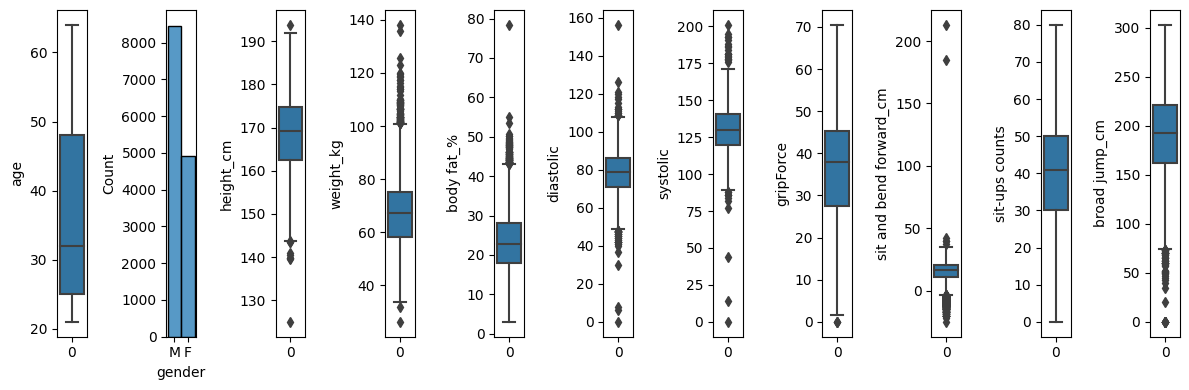

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

nn = len(feature_data.columns)
plt.figure(figsize=(12, 4))
for idx, col in enumerate(feature_data.columns):
    plt.subplot(1, nn, idx+1)
    if col=='gender':
        sns.histplot(feature_data[col])
    else:
        sns.boxplot(feature_data[col])
        plt.ylabel(col)
plt.tight_layout()
plt.show()

In [7]:
# 성별또한 숫자로 변경 / 남자:0, 여자:1
feature_data['gender'] = (feature_data['gender']=='F').astype(int)
feature_data['gender'].value_counts()

gender
0    8467
1    4926
Name: count, dtype: int64

In [8]:
# 함수에 넣게 묶어놓기
datas = (feature_data, label_data)

## 전 과정 함수화 하기

In [9]:
# 성능 평가지표 출력 함수
from sklearn.metrics import confusion_matrix,precision_score, \
recall_score, accuracy_score, f1_score, roc_curve, auc, roc_auc_score

def get_clf_eval(y_test, y_pred, y_pred_proba):
    print("< Confusion Matrix >")
    print(confusion_matrix(y_test, y_pred))
    
    print("Accuracy : ", end="")
    print(f"{accuracy_score(y_test, y_pred):.4f}", end=", ")
    
    print("Precision : ", end="")
    print(f"{precision_score(y_test, y_pred):.4f}", end=", ")
    
    print("Recall : ", end="")
    print(f"{recall_score(y_test, y_pred):.4f}", end=", ")
    
    print("F1 Score : ", end="")
    print(f"{f1_score(y_test, y_pred):.4f}", end=", ")
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    print("AUC of ROC : ", end="")
    print(f"{auc(fpr, tpr):.4f}")

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 단순 성능평가랑 Grid Search기능 모두 우겨넣기
def process(datas, is_scale=False, is_grid_search=False, param_grid=None, **params):
    feature_data, label_data = datas
    
    # 스케일링 여부
    if is_scale:
        feature_data = StandardScaler().fit_transform(feature_data)
    
    # 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(
        feature_data, label_data, test_size=0.3, random_state=0
    )
    
    if is_grid_search:
        lr_clf = LogisticRegression(solver='liblinear')
        # 폴드수 3, 5
        for cv in [3, 5]:
            grid_lr_clf = GridSearchCV(lr_clf, param_grid=param_grid, scoring='accuracy', cv=cv)
            grid_lr_clf.fit(X_train, y_train)

            result = pd.DataFrame(grid_lr_clf.cv_results_['params'])
            result['mean_score'] = grid_lr_clf.cv_results_['mean_test_score']
            print(result.sort_values(by='mean_score', ascending=False).head(10))
            print()
    else:
        # 모델 학습
        lr_clf = LogisticRegression(solver='liblinear', **params)
        lr_clf.fit(X_train, y_train)

        # 결과 출력
        y_pred = lr_clf.predict(X_test)
        y_pred_proba = lr_clf.predict_proba(X_test)[:,1]
        get_clf_eval(y_test, y_pred, y_pred_proba)

In [11]:
# Grid Search먼저 실행
param_grid = {
    'max_iter' : [100, 300, 500],
    'penalty' : ['l1', 'l2'],
    'C' : [0.1, 0.5, 1, 2, 5, 10]
}

process(datas=datas, is_grid_search=True, param_grid=param_grid)

       C  max_iter penalty  mean_score
35  10.0       500      l2    0.847573
33  10.0       300      l2    0.847467
29   5.0       500      l2    0.847253
9    0.5       300      l2    0.847040
21   2.0       300      l2    0.846720
23   2.0       500      l2    0.846720
27   5.0       300      l2    0.846720
17   1.0       500      l2    0.846507
11   0.5       500      l2    0.846080
15   1.0       300      l2    0.845867

       C  max_iter penalty  mean_score
15   1.0       300      l2    0.848107
27   5.0       300      l2    0.848107
17   1.0       500      l2    0.846933
23   2.0       500      l2    0.846933
11   0.5       500      l2    0.846827
29   5.0       500      l2    0.846827
35  10.0       500      l2    0.846720
33  10.0       300      l2    0.846720
21   2.0       300      l2    0.846400
9    0.5       300      l2    0.846400



In [27]:
# 스케일링 없음
process(datas=datas,
       max_iter=3000,
       penalty='l2',
       C=1
)

NameError: name 'process' is not defined

In [13]:
# 스케일링 있음
process(datas=datas, is_scale=True,
       max_iter=3000,
       penalty='l2',
       C=1
)
# 놀라울 정도로 차이가 없다

< Confusion Matrix >
[[2795  212]
 [ 392  619]]
Accuracy : 0.8497, Precision : 0.7449, Recall : 0.6123, F1 Score : 0.6721, AUC of ROC : 0.9235


## 다중 분류

In [1]:
import pandas as pd
import numpy as np

body = pd.read_csv('../data/bodyPerformance.csv')
body.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [2]:
feature_data = body.drop('class', axis=1)
label_data = body['class']

In [3]:
# 성별만 숫자로 변경 / 남자:0, 여자:1
feature_data['gender'] = (feature_data['gender']=='F').astype(int)
feature_data['gender'].value_counts()

gender
0    8467
1    4926
Name: count, dtype: int64

In [4]:
datas = (feature_data, label_data)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score

def process2(datas, is_scale=False, param_grid=None, **params):
    feature_data, label_data = datas
    
    # 스케일링 여부
    if is_scale:
        feature_data = StandardScaler().fit_transform(feature_data)
    
    # 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(
        feature_data, label_data, test_size=0.3, random_state=0
    )
    
    # 모델 학습
    lr_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', **params)
    lr_clf.fit(X_train, y_train)

    # 결과 출력
    y_pred = lr_clf.predict(X_test)
    y_pred_proba = lr_clf.predict_proba(X_test)
    
    print("< Confusion Matrix >")
    print(confusion_matrix(y_test, y_pred))
    print('\n---------------------\n')
    
    print(f'Accuracy : {accuracy_score(y_test, y_pred)*100:.2f}%')
    print('\n---------------------\n')
    
    precision = []
    recall = []
    indices = ['micro', 'macro', 'weighted']
    for l in indices:
        precision.append(precision_score(y_test, y_pred, average=l)*100)
        recall.append(recall_score(y_test, y_pred, average=l)*100)
    print(pd.DataFrame({'Precision Score(%)':precision, 'Recall Score(%)':recall}, index=indices))
    print('\n---------------------\n')
    
    print('ROC_AUC Score')
    print(f'ovo : {roc_auc_score(y_test, y_pred_proba, multi_class="ovo")*100:.2f}%')
    print(f'ovr : {roc_auc_score(y_test, y_pred_proba, multi_class="ovr")*100:.2f}%')

In [6]:
process2(datas=datas,
        max_iter=6000,
        C=1
)

< Confusion Matrix >
[[755 234  22   0]
 [214 459 287  34]
 [ 75 190 532 190]
 [ 15  37 158 816]]

---------------------

Accuracy : 63.76%

---------------------

          Precision Score(%)  Recall Score(%)
micro              63.763066        63.763066
macro              63.224942        63.572118
weighted           63.397800        63.763066

---------------------

ROC_AUC Score
ovo : 85.91%
ovr : 85.99%


In [7]:
# 스케일링 하는게 훨씬 빠르다
process2(datas=datas, is_scale=True,
        max_iter=100,
        C=1
)

< Confusion Matrix >
[[749 241  21   0]
 [215 460 281  38]
 [ 72 194 534 187]
 [ 15  38 157 816]]

---------------------

Accuracy : 63.69%

---------------------

          Precision Score(%)  Recall Score(%)
micro              63.688402        63.688402
macro              63.182847        63.499559
weighted           63.354513        63.688402

---------------------

ROC_AUC Score
ovo : 85.93%
ovr : 86.01%


In [8]:
process2(datas=datas, is_scale=True,
        max_iter=100,
        C=0.2
)

< Confusion Matrix >
[[754 236  21   0]
 [222 452 283  37]
 [ 74 191 534 188]
 [ 15  41 155 815]]

---------------------

Accuracy : 63.59%

---------------------

          Precision Score(%)  Recall Score(%)
micro              63.588850        63.588850
macro              63.017594        63.397626
weighted           63.188845        63.588850

---------------------

ROC_AUC Score
ovo : 85.92%
ovr : 86.00%


In [9]:
process2(datas=datas, is_scale=True,
        max_iter=100,
        C=5
)

< Confusion Matrix >
[[750 240  21   0]
 [215 461 280  38]
 [ 72 194 534 187]
 [ 15  38 157 816]]

---------------------

Accuracy : 63.74%

---------------------

          Precision Score(%)  Recall Score(%)
micro              63.738178        63.738178
macro              63.230023        63.549438
weighted           63.401217        63.738178

---------------------

ROC_AUC Score
ovo : 85.93%
ovr : 86.01%
